# TFM: Equivariance, Invariance and symmetries in Quantum Machine Learning

We do a brief summary of the main point: 

Group theory is a prevalent mathematical tool in many areas of physics, and it has become standard for studying symmetries. For instance, it is fundamental in the construction of the standard model and nuclear physics. By taking these tools of group theory and considering them during the design of quantum variational circuits, the structure of a quantum machine learning model can be endowed with some symmetries of the problem and this can result in exponential reductions of complexity and also speedups. At the same time, this is not a magical tool, some authors have related this exponential downscaling of hilbert space to a classical simulability of the problem. [Cerezo, et al. “Does Provable Absence of Barren Plateaus Imply Classical Simulability? Or, Why We Need to Rethink Variational Quantum Computing.” arXiv, March 19, 2024. https://doi.org/10.48550/arXiv.2312.09121].

At the same time, ignoring this, it also presents other challenges. For instance, while our problem may be reduced to a much smaller subspace limited by the symmetry, one is precisely constrained to their initial ansatz's symmetry eigenstate. Likewise, more barren plateaus may appear by constricting the evolution of parametrized circuits into this symmetric region, and sometimes it may be wortwhile to add a little of asymetry terms to counteract this.




We start by talking about groups. The symmetries of our problem may be described by the elements of a group $G$. For instance, it could have permutation symmetry ($g\in S_N$, symmetric group). The important tool for quantum circuits is how the symmetry is represented in our instance of the problem. This is well studied via representation theory, which maps group elements to linear operators.

In our case, the idea will be that given the group of symmetries of our problem, we will want to encode our problem in a circuit and this will in turn define how the representation of our symmetry appears (i.e. permutation symmetry could then appear as invariance under SWAP gates of wires). But at the same time, there have been approaches where the representation of the symmetry is given first and then an encoding is learned that respects this symmetry, such as in: 
Bradshaw, Zachary P., Ethan N. Evans, Matthew Cook, i Margarite L. LaBorde. «Learning Equivariant Maps with Variational Quantum Circuits». arXiv, 16 desembre 2024. https://doi.org/10.48550/arXiv.2412.11889.



## Theory Background

Representation theory: If we have a group describing symmetries of our problem $g, h\in G, gh \in G$, we will consider a representation of our group into unitary gates (in general a representation is onto linear operators), as such as they will act on our problem. $W: G\to \mathcal{U(H)}$

$$W(gh) =W(g)W(h), \quad W(g^{-1})=W(g)^{-1} \stackrel{\text{for unitary repr.}}{=} W(g)^\dag $$

## First Example: Rows or Columns?




We will want to replicate simple problem of identifying lines in image:

$$\begin{bmatrix}x_1 & x_2 \\ x_3 & x_4\end{bmatrix}$$

$x_1 = x_2 = 1$, $x_3 = x_4 = 0$

$x_1 = x_2 = 0$, $x_3 = x_4 = 1$


Horizontal lines



$x_1 = x_3 = 1$, $x_2 = x_4 = 0$

$x_1 = x_3 = 0$, $x_2 = x_4 = 1$


Vertical lines


Symmetry group corresponds to $Z_2 \times Z_2$ or also written $C_2 \times C_2$: We can swap horizontal rows, own inverse operation, and same with columns. Each of these swaps then corresponds to a group element of our symmetries, and in total we only have these two operations and the combination of both (+ the identity). This defines our symmetry group $G$.

Now, what we will work with in our Quantum Circuit will be with a representation of our group. The linear operators that describe the group operations are the important aspects we will deal with, and this depends on how we encode our problem.

We will encode it as a vector, our image can be unraveled:
$x_1, x_2, x_3, x_4$.

This can be corresponded with two qubits, in amplitude encoding:

$$x_1 \ket{00} + x_2 \ket{01} + x_3 \ket{10} + x_4 \ket{11}$$
Up to normalization

But we will need also an output qubit to measure. We could perform the measurement directly on our two wires, but to preserve our symmetries it could be a bit hard, so we just implement an extra output qubit/wire.


The representation of the symmetries of the problem become:
$$(I\otimes X), \quad (X \otimes I)$$

Where the first swaps columns and the second swaps rows. And identity is implicit in our readout qubit.

Now, we want our circuit to become a classifier:
$$f_\theta(x) = Tr [U_\theta \mathcal{E}(x) \ket{0}\bra{0}  \mathcal{E}(x)^\dag U_\theta ^\dag \hat{O}] $$

Invariance will happen when $f(V(g)x) = f(x)$, where $V(g)$ represents how a symmetry group element acts on the data space.

For our case, this means that given our encoding, we already know how the symmetry group element representations act on our qubits with the swap operations. Therefore, to have invariance as a whole, we can impose that these operators commute with our circuit $U$ and with our measurement $O$.

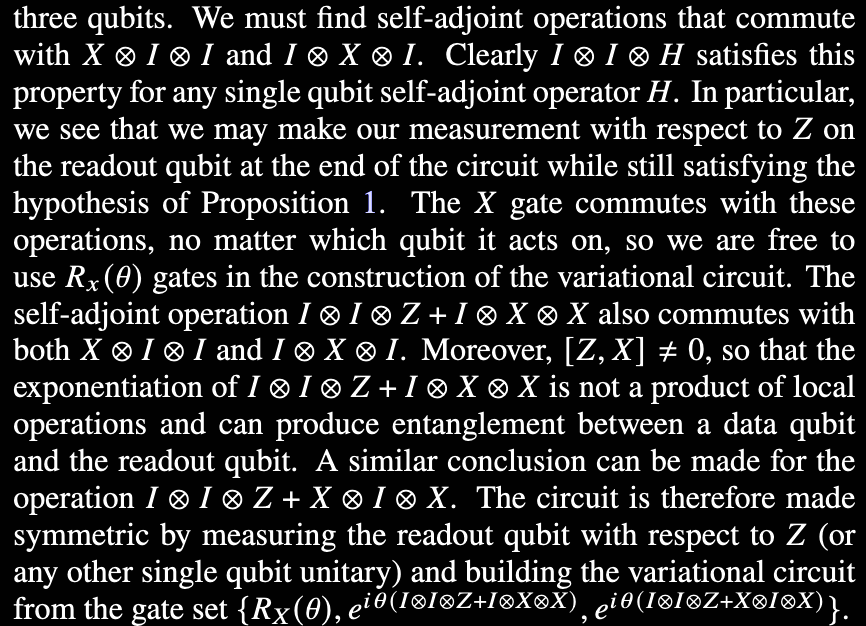


## Qibo TFG

In [1]:
import numpy as np
from qibo import Circuit, gates
import qibo
qibo.set_backend("tensorflow")

[Qibo 0.2.2|INFO|2025-03-11 09:29:56]: Using tensorflow backend on /device:CPU:0


In [2]:
# Problem with qibo. We need to have ALL parameters be the parameters we tune, to not make it messy. 
# So we can't use rotations freely

def one_qubit_unitary(circ, bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    circ.add(gates.RX(bit, symbols[0]))
    circ.add(gates.RY(bit, symbols[1]))
    circ.add(gates.RZ(bit, symbols[2]))


# https://arxiv.org/pdf/quant-ph/0308006.pdf
def two_qubit_unitary(circ, bits, symbols, full=False, onlyEnd=False):
    # bits = (a, b)
    """Make a Cirq circuit that creates a non arbitrary two qubit unitary."""
    if full and not onlyEnd:
        one_qubit_unitary(circ, bits[0], symbols[0:3])
        one_qubit_unitary(circ, bits[1], symbols[3:6])
    
    cond = full*(not onlyEnd)
        
    circ.add(gates.CNOT(bits[1],bits[0]))
    
    circ.add(gates.RZ(bits[0], symbols[0+6*cond]))
    circ.add(gates.RY(bits[1], symbols[1+6*cond]))
    
    circ.add(gates.CNOT(bits[0],bits[1]))
    
    circ.add(gates.RY(bits[1], symbols[2+6*cond]))
    
    circ.add(gates.CNOT(bits[1],bits[0]))
        
    if full and not onlyEnd: 
        one_qubit_unitary(circ, bits[0], symbols[9:12])
        one_qubit_unitary(circ, bits[1], symbols[12:])
        
    if full and onlyEnd:
        one_qubit_unitary(circ, bits[1], symbols[3:])


In [8]:
circ = Circuit(2)
param = np.random.random(16)
two_qubit_unitary(circ, (0,1), param)

print(circ.draw())

q0: ─X─RZ─o────X─
q1: ─o─RY─X─RY─o─


In [3]:
circ = Circuit(2)
circ.add(gates.X(1))
circ.execute().state()

<tf.Tensor: shape=(4,), dtype=complex128, numpy=array([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])>

In [4]:
from numpy import pi

# observables have to be included
def parameter_shift_exp(circ, obs, param, nrep=None, initial_state=None):
    params = np.asarray(circ.get_parameters()).copy()
    modified = params.copy()
    #for _ in range(nrep):
    modified[param] = params[param]+pi/2
    circ.set_parameters(modified)
    fp = obs.expectation(circ(initial_state,nshots=nrep).state())
    
    modified[param] = params[param]-pi/2
    circ.set_parameters(modified)
    fm = obs.expectation(circ(initial_state,nshots=nrep).state())
    
    circ.set_parameters(params)
    
    return 1/2*(fp - fm)
    

# Actually, this was implemented!!!: https://github.com/qiboteam/adiabatic-fit/blob/main/src/adiabatic-fit/psr.py

def parameter_shift(
    circuit,
    hamiltonian,
    parameter_index,
    initial_state=None,
    scale_factor=1,
    nshots=None,
    nruns=None
):
    """In this method the parameter shift rule (PSR) is implemented.
    Given a circuit U and an observable H, the PSR allows to calculate the derivative
    of the expected value of H on the final state with respect to a variational
    parameter of the circuit.
    There is also the possibility of setting a scale factor. It is useful when a
    circuit's parameter is obtained by combination of a variational
    parameter and an external object, such as a training variable in a Quantum
    Machine Learning problem. For example, performing a re-uploading strategy
    to embed some data into a circuit, we apply to the quantum state rotations
    whose angles are in the form: theta' = theta * x, where theta is a variational
    parameter and x an input variable. The PSR allows to calculate the derivative
    with respect of theta' but, if we want to optimize a system with respect its
    variational parameters we need to "free" this procedure from the x depencency.
    If the `scale_factor` is not provided, it is set equal to one and doesn't
    affect the calculation.
    Args:
        circuit (:class:`qibo.models.circuit.Circuit`): custom quantum circuit.
        hamiltonian (:class:`qibo.hamiltonians.Hamiltonian`): target observable.
        parameter_index (int): the index which identifies the target parameter in the circuit.get_parameters() list
        initial_state ((2**nqubits) vector): initial state on which the circuit acts (default None).
        scale_factor (float): parameter scale factor (default None).
    Returns:
        np.float value of the derivative of the expectation value of the hamiltonian
        with respect to the target variational parameter.
    Example:
        .. testcode::
            import qibo
            import numpy as np
            from qibo import hamiltonians, gates
            from qibo.models import Circuit
            from qibo.derivative import parameter_shift
            # defining an observable
            def hamiltonian(nqubits = 1):
                m0 = (1/nqubits)*hamiltonians.Z(nqubits).matrix
                ham = hamiltonians.Hamiltonian(nqubits, m0)
                return ham
            # defining a dummy circuit
            def circuit(nqubits = 1):
                c = Circuit(nqubits = 1)
                c.add(gates.RY(q = 0, theta = 0))
                c.add(gates.RX(q = 0, theta = 0))
                c.add(gates.M(0))
                return c
            # initializing the circuit
            c = circuit(nqubits = 1)
            # some parameters
            test_params = np.random.randn(2)
            c.set_parameters(test_params)
            test_hamiltonian = hamiltonian()
            # running the psr with respect to the two parameters
            grad_0 = parameter_shift(circuit = c, hamiltonian = test_hamiltonian, parameter_index = 0)
            grad_1 = parameter_shift(circuit = c, hamiltonian = test_hamiltonian, parameter_index = 1)
    """

    # inheriting hamiltonian's backend
    backend = hamiltonian.backend

    # getting the gate's type
    gate = circuit.associate_gates_with_parameters()[parameter_index]

    # getting the generator_eigenvalue
    generator_eigenval = gate.generator_eigenvalue()

    # defining the shift according to the psr
    s = np.pi / (4 * generator_eigenval)

    # saving original parameters and making a copy
    original = np.asarray(circuit.get_parameters()).copy()
    shifted = original.copy()

    # forward shift and evaluation
    shifted[parameter_index] += s
    circuit.set_parameters(shifted)

    forward = 0
    backward = 0


    if nshots == None:
        forward = hamiltonian.expectation(
            backend.execute_circuit(circuit=circuit, initial_state=initial_state).state()
        )

        # backward shift and evaluation
        shifted[parameter_index] -= 2 * s
        circuit.set_parameters(shifted)

        backward = hamiltonian.expectation(
            backend.execute_circuit(circuit=circuit, initial_state=initial_state).state()
        )

    else:
        
        copied = shifted.copy()

        for _ in range(nruns):

            forward += backend.execute_circuit(
                circuit=circuit, 
                initial_state=initial_state, 
                nshots=nshots
                ).expectation_from_samples(hamiltonian)

            # backward shift and evaluation
            shifted[parameter_index] -= 2 * s
            circuit.set_parameters(shifted)

            backward += backend.execute_circuit(
                circuit=circuit, 
                initial_state=initial_state, 
                nshots=nshots
                ).expectation_from_samples(hamiltonian)  

            # restoring the original circuit
            shifted = copied.copy()
            circuit.set_parameters(copied)

        forward /= nruns
        backward /= nruns
            
    circuit.set_parameters(original)
        

    return generator_eigenval * (forward - backward) * scale_factor

In [5]:
import matplotlib.pyplot as plt
from qibo.backends import GlobalBackend
from qibo.hamiltonians import SymbolicHamiltonian
backend = GlobalBackend()
from qibo.symbols import Z, X, Y

def pred(circ, obs, initial_state=None, nshots=None):
    if nshots is None:
        return obs.expectation(backend.execute_circuit(circuit=circ, initial_state=initial_state).state())
    else: return backend.execute_circuit(circuit=circ, initial_state=initial_state, nshots=nshots).expectation_from_samples(obs)
    

## For our problem

### Matrix backend

In [1]:
import numpy as np
X = np.array([[0,1],[1,0]], dtype=np.complex_)
Y = np.array([[0,-1j],[1j,0]], dtype=np.complex_)
Z = np.array([[1,0],[0,-1]], dtype=np.complex_)
I = np.array([[1,0],[0,1]], dtype=np.complex_)

def pauli(s):
  if s == 'X': return X
  if s == 'Y': return Y
  if s == 'Z': return Z
  return I

def pauliString(string):
  p = pauli(string[0])
  for s in string[1:]:
    p = np.kron(p, pauli(s))
  return p

In [2]:
import matplotlib.pyplot as plt
import torch as pt
from torch import matrix_exp as expm
from torch.linalg import eigh as eigh
import numpy as np

In [3]:
I = pt.tensor([[1.,0],[0j,1.]])
X = pt.tensor([[0j,1.],[1.,0]])
Y = 1j*pt.tensor([[0,-1.],[1.,0]])
Z = pt.tensor([[1.,0],[0j,-1.]])
H = 1.0/pt.sqrt(pt.tensor(2))*pt.tensor([[1,1+0j],[1+0j,-1]])

P0 = pt.tensor([[1.,0],[0j,0]])  # 0 projector
P1 = pt.tensor([[0.,0],[0j,1]])  # 1 projector

ket0 = pt.tensor([1, 0.j])
ket1 = pt.tensor([0.j,1])

ketp = H@ket0
ketm = H@ket1

def statevector(states):
  tot_state = pt.tensor([1])
  for state in states:
    tot_state = pt.kron(tot_state, state)
  return tot_state

def pauli(s):
  if s == 'X': return X
  if s == 'Y': return Y
  if s == 'Z': return Z
  if s == 'H': return H
  if s == 'D': return P1
  if s == 'U': return P0
  return I

def pauliString(string):
  if string == '': return pt.tensor(1+0j)
  p = pauli(string[0])
  for s in string[1:]:
    p = pt.kron(p, pauli(s))
  return p


def idK(k):
  return pauliString('I'*k)


def operatorN(op, qubit, L):
  return pt.kron(idK(qubit), pt.kron(op, idK(L-qubit-1)))


def printState(state, tol=1e-6):
  L = int(np.ceil(np.log2(len(state))))
  for it, coef in enumerate(state):
    if pt.abs(coef)>tol:
        print(coef.item(), "|{}>".format(("0"*L+bin(it)[2:])[-L:]))   

In [4]:
def problemHamiltonian(delta, L):
    Ham = pauliString('X'+'I'*(L-2)+'X') + pauliString('Y'+'I'*(L-2)+'Y') + delta * pauliString('Z'+'I'*(L-2)+'Z')
    for l in range(L-1):
        Ham += pauliString('I'*(l)+'XX'+'I'*(L-l-2)) + pauliString('I'*(l)+'YY'+'I'*(L-l-2)) + delta * pauliString('I'*(l)+'ZZ'+'I'*(L-l-2))
    return -Ham

def expectation(psi, operator):
    return pt.inner(pt.conj(psi), operator@psi)

def pauliSum(op, rang, L):
    if type(op) is str:
        op = pauli(op)
    sumOp = idK(L)*0
    for r in rang:
        sumOp += operatorN(op, r, L)
    return sumOp

def gstate(Ham):
    eval, estate = eigh(Ham)
    return estate[:,0], eval[0]

def bip_entanglement_entropy(psi, N=None):
    if N is None:
        N = int(np.log2(len(psi)))
    
    psiMat = psi.reshape((2**(N//2), 2**((N+1)//2)))
    u, s, vh = pt.linalg.svd(psiMat)
    s = s[s>0]**2
    return -pt.sum(s*pt.log2(s))

In [5]:
# We fix L = 6
L = 6

def CNOT(control, target, L):
    Is = 'I'*L
    if target > control:
        return pauliString(Is[:control]+'D'+Is[control+1:target]+'X'+Is[target+1:]) + pauliString(Is[:control]+'U'+Is[control+1:])
    return pauliString(Is[:target]+'D'+Is[target+1:control]+'X'+Is[control+1:]) + pauliString(Is[:target]+'U'+Is[target+1:])

def CZ(control, target, L):
    if control > target: control, target = target, control
    Is = 'I'*L
    return idK(L)-2*pauliString(Is[:control]+'D'+Is[control+1:target]+'D'+Is[target+1:])

def Rx1(alpha):
    return expm(-1j * alpha/2 * X)
def Rx(alpha, qubit, L):
    return operatorN(Rx1(alpha), qubit, L)
def Ry1(alpha):
    return expm(-1j * alpha/2 * X)
def Ry(alpha, qubit, L):
    return operatorN(Ry1(alpha), qubit, L)
def Rz1(alpha):
    return expm(-1j * alpha/2 * X)
def Rz(alpha, qubit, L):
    return operatorN(Rz1(alpha), qubit, L)


### Qibo circuit

In [6]:
nqubits = 3
ent1 = qibo.hamiltonians.Hamiltonian(nqubits, pauliString('IIZ')+pauliString('IXX')).exp(-np.pi/2)
ent2 = qibo.hamiltonians.Hamiltonian(nqubits, pauliString('IIZ')+pauliString('XIX')).exp(-np.pi/2)

circ = Circuit(nqubits)

circ.add(ent2)

print(circ.draw())

NameError: name 'qibo' is not defined

In [12]:
def solution_circuit(circ, bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    circ.add(gates.RX(bit, symbols[0]))
    circ.add(gates.RY(bit, symbols[1]))
    circ.add(gates.RZ(bit, symbols[2]))

In [13]:
# similar but faster?
de = 0.01

# (l-pred)^2  -> gradient = -2*(l-pred)*gradPred

n = 4

testFast, labelFast = (uncut[:] for uncut in generate_data(n))

init_state = np.zeros(2**(n+1))

trainSize = len(test)
loss = []
lossC = 0

bestParam = None
bestLoss = 1

nbatch = 100

print(circ.get_parameters())

for _ in range(1):
    for __ in range(nbatch): # batch
        t0 = time()
        lossC = 0
        gradient = np.zeros(len(parameters))
        for tes, lab in zip(testFast, labelFast):
            ###t0 = time()
            num = int(tes, base=2)*2

            init_state[num] = 1
            
            #totalGradient = 0
            predVal = pred(circ,obs,init_state)
            
            for param in range(len(parameters)):
                paramBase = param if param < 3 else param%3 + 3*n*(param//3)
                for qbit in range(n):
                    gradient[param] += -2*(lab-predVal)*parameter_shift(circ, obs, paramBase + 3*qbit, initial_state=init_state)
                    
            lossC += (lab-predVal)**2
            
            init_state[num] = 0
            ###print(time()-t0)
        
        loss.append(lossC/trainSize)
        if lossC/trainSize < bestLoss:
            bestParam = circ.get_parameters()
            bestLoss = lossC/trainSize
        
        circParam = np.asarray(circ.get_parameters())[:,0]
        ####gradient *= -2*(lab-predVal)
        for param in range(len(parameters)):
            paramBase = param if param < 3 else param%3 + 3*n*(param//3)
            for qbit in range(n):
                circParam[paramBase + 3*qbit] -= gradient[param]*de
        circ.set_parameters(circParam)
        
        
        
        print(time()-t0)
        
print(circ.get_parameters())
        

NameError: name 'generate_data' is not defined

### Generic Functions


Here we define generic functions to be used during our otpimization. We have our parametrized circuit.

In [7]:
# Test to show we can define circ func in terms of some parameters

def f(x, y):
    return x + y

f(np.array([1,2]), np.array([1,2]))

x = np.array([1,2])

g = lambda y: f(x,y)

print(g(x*0 + 1))

x[0] = 2 

print(g(x*0 + 1))

[2 3]
[3 3]


In [8]:
def runCircuit(state, circuit, observable):
    return pt.real(expectation(circuit@state, observable))


def runVariational(input, encoder, circuit, observable):
    return runCircuit(encoder(input), circuit, observable)


def runVariational(N, input, encoder_func, parameters, circ_func, observable, encoder_type = 'state', hyper={}):
    circuit = circ_func(parameters, N, hyper)
    if encoder_type == 'state':
        state = encoder_func(input, N, hyper)
    else:
        encoder = encoder_func(input, N, hyper)
        state = encoder@statevector([ket0]*N)
    return runCircuit(state, circuit, observable)


def simpleOptimizer(N, inputs, encoder_func, parameters, circ_func, observable, loss_func,Nepochs=250, lr=1e-2, epochs_print = 50, encoder_type='state', hyper={}):
    loss_list = pt.empty((Nepochs,))
    for epoch in range(Nepochs):
        loss = 0
        for input in inputs:
            out = runVariational(N, input, encoder_func, parameters, circ_func, observable, encoder_type=encoder_type)
            loss += loss_func(out, input)   # loss can depend on input. E.G. Inputs could be prelabeled, we want output to correspond to each label

        loss.backward()  # we compute gradients
        
        with pt.no_grad():
            parameters = parameters - lr * parameters.grad      # update gradients
        parameters.requires_grad = True
        
        if epoch % epochs_print == 0 or epoch == Nepochs - 1:
            print(f"Epoch {epoch}, Loss: {loss}")
        loss_list[epoch] = loss
    
    return parameters, loss_list.detach().numpy()

def genericOptimizer(N, inputs, encoder_func, optimizer, circ_func, observable, loss_func,Nepochs=250, lr=1e-2, epochs_print = 50, encoder_type='state', hyper={}, optimizer_closure=False):
    loss_list = pt.empty((Nepochs,))
    for epoch in range(Nepochs):
        def closure():
            optimizer.zero_grad()
            loss = 0
            for input in inputs:
                out = runVariational(N, input, encoder_func, optimizer._params[0], circ_func, observable, encoder_type=encoder_type)
                loss += loss_func(out, input)   # loss can depend on input. E.G. Inputs could be prelabeled, we want output to correspond to each label

            loss.backward()  # we compute gradients
        
        if optimizer_closure:
            optimizer.step(closure)  # Some optimizers need to reevaluate the function multiple times. So they need to call the closure func many times
        else:
            closure()
            optimizer.step()
        
        if epoch % epochs_print == 0 or epoch == Nepochs - 1:
            print(f"Epoch {epoch}, Loss: {loss}")
        loss_list[epoch] = loss
    
    return optimizer, loss_list.detach().numpy()



### Manual circuit


We implement a manual circuit with pytorch as we cannot write our gates in qibo out from matrix representation directly

In [13]:
def simpleCircuit6(params, N=3, hyper={}):
    # N = 3 regardless
    r = pauliString('IIH')
    r = expm(1j * params[1] * (pauliString('IIZ')+pauliString('IXX'))/pt.sqrt(pt.tensor(2)) ) @ r
    r = Rx(params[0], 2, 3)@r
    r = expm(1j * params[2] * (pauliString('IIZ')+pauliString('XIX'))/pt.sqrt(pt.tensor(2)) )@r
    r = pauliString('IIH')@r
    return r

def encode(x, N=3, hyper={}):
    # N = 3 regardless
    res = x[0]*statevector([ket0,ket0,ket0])+x[1]*statevector([ket0,ket1,ket0])+x[2]*statevector([ket1,ket0,ket0])+x[3]*statevector([ket1,ket1,ket0])
    res = res / (pt.norm(x))
    return res


In [12]:
L = 3

#exactG, exactE = gstate(Ham)
params = pt.rand((3))#, requires_grad=True)

x = pt.tensor([1.+0j,1.+0j,0.+0j,0.+0j])

def loss_func(out, input):
    return (out-pt.tensor(1))**2

s0 = encode(x, L)


Np = 101

vals = np.empty((Np, Np))
for it1, pzz in enumerate(pt.linspace(0,2, Np)):
    for it2, px in enumerate(pt.linspace(0,2, Np)):
        params[0] = px*pt.pi
        params[1] = pzz*pt.pi
        params[2] = -pzz*pt.pi
        vals[it1, it2] = runVariational(L, x, encode, params, simpleCircuit6, observable = pauliString('IIZ'))

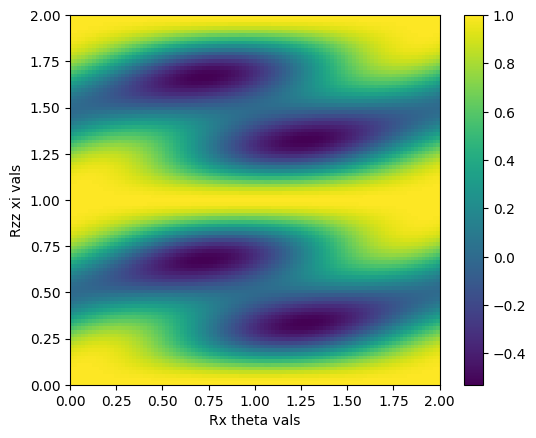

In [14]:
plt.imshow(vals, extent=(0,2,0,2), origin='lower')
plt.xlabel('Rx theta vals')
plt.ylabel('Rzz xi vals')
plt.colorbar()
plt.show()

In [11]:
L = 3

#exactG, exactE = gstate(Ham)
params = pt.rand((3), requires_grad=True)

x1 = pt.tensor([1.+0j,1.+0j,0.+0j,0.+0j])
x2 = pt.tensor([1.+0j,0.+0j,1.+0j,0.+0j])

def loss_func(out, input):
    if x2[1] == 1.+0j:
        return (out-pt.tensor(1))**2
    return (out+pt.tensor(1))**2

s0 = encode(x, L)

print(expectation(simpleCircuit6([1,1,1])@s0, pauliString('IIZ')))

print(s0)


lr = 0.1
Nepochs = 50000

params, loss_list = simpleOptimizer(L, [x1, x2], encode, params, simpleCircuit6, observable = pauliString('IIZ'), loss_func=loss_func, 
                Nepochs=Nepochs, lr=lr)



tensor(-0.5212+8.2985e-09j)
tensor([0.7071+0.j, 0.0000+0.j, 0.7071+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
        0.0000+0.j])
Epoch 0, Loss: 2.4196889400482178
Epoch 50, Loss: 0.43872231245040894
Epoch 100, Loss: 0.43872225284576416
Epoch 150, Loss: 0.4387223720550537
Epoch 200, Loss: 0.4387223720550537
Epoch 250, Loss: 0.4387223720550537
Epoch 300, Loss: 0.4387223720550537
Epoch 350, Loss: 0.4387223720550537
Epoch 400, Loss: 0.4387223720550537
Epoch 450, Loss: 0.4387223720550537
Epoch 500, Loss: 0.4387223720550537
Epoch 550, Loss: 0.4387223720550537
Epoch 600, Loss: 0.4387223720550537
Epoch 650, Loss: 0.4387223720550537
Epoch 700, Loss: 0.4387223720550537
Epoch 750, Loss: 0.4387223720550537
Epoch 800, Loss: 0.4387223720550537
Epoch 850, Loss: 0.4387223720550537
Epoch 900, Loss: 0.4387223720550537
Epoch 950, Loss: 0.4387223720550537
Epoch 1000, Loss: 0.4387223720550537
Epoch 1050, Loss: 0.4387223720550537
Epoch 1100, Loss: 0.4387223720550537
Epoch 1150, Loss: 0.438722372

tensor([-0.0031,  0.0877, -0.0877], requires_grad=True)


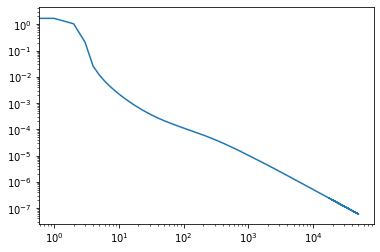

In [319]:

print(params)
plt.loglog()
plt.plot(loss_list)

In [349]:
print("ROW")
x = pt.tensor([1.,1.,0+0j,0+0j])
s0 = encode(x)
circ0 = simpleCircuit6(params)
print(pt.real(expectation(circ0@s0, pauliString('IIZ'))))

x = pt.tensor([0.,0.,1+0j,1+0j])
s0 = encode(x)
circ0 = simpleCircuit6(params)
print(pt.real(expectation(circ0@s0, pauliString('IIZ'))))

print("\nCOLUMN")

x = pt.tensor([1.,0.,1+0j,0+0j])
s0 = encode(x)
circ0 = simpleCircuit6(params)
print(pt.real(expectation(circ0@s0, pauliString('IIZ'))))

x = pt.tensor([0.,1.,0+0j,1+0j])
s0 = encode(x)
circ0 = simpleCircuit6(params)
print(pt.real(expectation(circ0@s0, pauliString('IIZ'))))


ROW
tensor(1.0000)
tensor(1.0000)

COLUMN
tensor(1.0000)
tensor(1.0000)


## More complex problem

Spin chain: Translational symmetry.

Very similar to $Z_2$ group, now $Z_L$

$$\hat{H} = -\sum_i\hat{X}_i\hat{X}_{i+1} +\hat{Y}_i\hat{Y}_{i+1}+\delta\hat{Z}_i\hat{Z}_{i+1} $$

Our hamiltonian commutes with the $\sum Z_i$ operator. In particular, we notice that if we had $\delta=1$, we would have global SO(3) symmetry, as we could rotate our system and that would not affect results, for the $\delta=1$ case we would only care about spin alignment.
But for $\delta\not = 1$ this symmetry is broken, instead now we only have symmetry with respect with rotations in the $Z$ direction. (commutation with Z, implies commutation with $exp(kZ)$)


The second symmetry is the translational symmetry of our chain. We can translate our whole chain.



These two symmetries validate our results for the first part. Indeed, we observe that by the commutation of $[H,\sum Z_i]=0$, our ground state will also be an eigenvalue. That is, it must correspond to some combination that is a particular eigenvalue of $\sum Z_i$. This means that as a combination of states in the computational basis $|s_1 s_2 \dots s_L\rangle$, it must only be a combination of terms such that $\sum s_i = z$ for some particular z.


Similarly, the translational symmetry impplies also that for any particular translation shift by $n$ sites, it commutes with the Hamiltonian, so for each of them there must be a common basis such that the ground state is also an eigenvector. In particular, then, as shifts commute between themselves, the ground state of our system will be an eigenvalue of all the translation operators at the same time.

If we only had $L=2$, then we would have for the $T_1$ translation either eigenvalues $+1$ or $-1$. But for a general case, we can also just chose the eigenvalues of $T_1$, which will be one of $e^{\frac{2\pi n}{L} i}$, as the eigenvalues of the ohter translation operators are just related to $T_1$ by $T_n = T_1 ^n$ .

We will implement both symmetries. First we implement a simple model implementing none.

In [353]:
def one_qubit_unitary(bit, symbols):
    return Rz(symbols[2], bit, L)@Ry(symbols[1], bit, L)@Rx(symbols[0], bit, L)


def two_qubit_unitary(bits, symbols, L, full=False, onlyEnd=False):
    # bits = (a, b)
    #if full and not onlyEnd:
    r =one_qubit_unitary(bits[0], symbols[0:3])
    r = one_qubit_unitary(bits[1], symbols[3:6])@r
    r = CNOT(bits[1], bits[0], L)@r
    
    return r

def simpleCircuit6(params):
    r = one_qubit_unitary(0, params[:3])
    for q in range(1,L):
        r = one_qubit_unitary(q, params[3*q:3*(q+1)])@r
    for q in range(0,L):
        r = CNOT(q, (q+1)%L, L)@r
    return r

In [200]:
L = 6
delta = -1

Ham = problemHamiltonian(delta, L)

exactG, exactE = gstate(Ham)
params = pt.rand((L*3*1*2), requires_grad=True)


s0 = statevector([ket0]*L)


print("Exact E:", exactE)

lr = 0.05
Nepochs = 250
for epoch in range(Nepochs):
    circ0 = simpleCircuit6(params[L*3:])@simpleCircuit6(params[:L*3])
    energy = pt.real(expectation(circ0@s0, Ham)) # we want to minimize energy!!!
    energy.backward()  # we compute gradients
    
    with pt.no_grad():
        params = params - lr * params.grad
    params.requires_grad = True
    if epoch % 10 == 0 or epoch == Nepochs - 1:
        print(f"Epoch {epoch}, Energy: {energy}")



Exact E: tensor(-11.2111)
Epoch 0, Energy: -0.015690766274929047
Epoch 10, Energy: -0.9518724083900452
Epoch 20, Energy: -1.3002926111221313
Epoch 30, Energy: -1.3791606426239014
Epoch 40, Energy: -1.4007893800735474
Epoch 50, Energy: -1.4084758758544922
Epoch 60, Energy: -1.4116432666778564
Epoch 70, Energy: -1.4130094051361084
Epoch 80, Energy: -1.4136053323745728
Epoch 90, Energy: -1.4138669967651367
Epoch 100, Energy: -1.4139797687530518
Epoch 110, Energy: -1.4140300750732422
Epoch 120, Energy: -1.4140516519546509
Epoch 130, Energy: -1.4140598773956299
Epoch 140, Energy: -1.4140651226043701
Epoch 150, Energy: -1.4140663146972656
Epoch 160, Energy: -1.4140679836273193
Epoch 170, Energy: -1.4140690565109253
Epoch 180, Energy: -1.414068341255188
Epoch 190, Energy: -1.4140682220458984
Epoch 200, Energy: -1.4140682220458984
Epoch 210, Energy: -1.414068579673767
Epoch 220, Energy: -1.4140682220458984
Epoch 230, Energy: -1.4140688180923462
Epoch 240, Energy: -1.4140677452087402
Epoch 249,

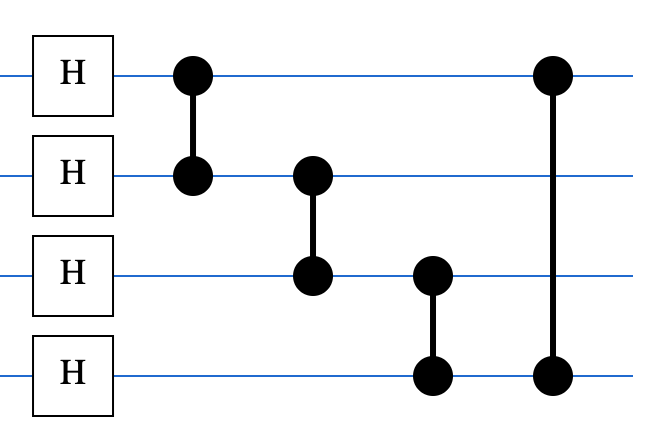


Now we consider the case of translational symmetry. A simple way to obtain a symmetry respecting version of an operator is to perfrom its "twirl". We will consider which are the symmetry respecting generators, first the case of single qubit generators:

$$I_1\otimes\dots\otimes P_i\otimes\dots\otimes I_n$$

The twirl of these pauli gates:
$$\mathcal{T}_G(P_i)=\frac{1}{|G|}\sum_{g\in G} W(g)(I_1\otimes\dots\otimes P_i\otimes\dots\otimes I_n) W(g)^\dag$$

Where in this case $G$ is the group of translations $\{I, T_1, \dots, T_{n-1}\}$ and therefore we obtain:
$$\mathcal{T}_G(P_i) = \frac{1}{n} \bigg(P_1 \otimes\dots I_n +I_1\otimes P_2 \otimes\dots I_n +\dots+ I_1 \otimes\dots P_n\bigg)$$

This makes sense, what it is telling us is just instead of applying rotations in a single qubit, to respect our translation symmetry we need instead apply the same in all qubits at once.

But how can we perform entanglement then? It is tempting to think that a cascade of CNOTs is translationally invariant, but that is not true. The first control qubit alters the first target qubits, which means the second control qubit has been altered by the first before applyin the second CNOT. Clearly this is not treating the second qubit the same as the first, as the first one was not affected before applyin the CNOT.

So instead of applying a CNOT we will consider CZ gates. The advantage they have is that they are symmetric in its inputs, and they commute among themselves. This can be easily understood as what a CZ gate does is apply a -1 phase if a state is in $\ket{11}$. The order of the CZ gates applied does not alter the total phase aquired.

$$CZ_{i,j} = \ket{0}_i\otimes\ket{0}_j \bra{0}_i\otimes\bra{0}_j + \ket{0}_i\otimes\ket{1}_j \bra{0}_i\otimes\bra{1}_j + \ket{1}_i\otimes\ket{0}_j \bra{1}_i\otimes\bra{0}_j - \ket{1}_i\otimes\ket{1}_j \bra{1}_i\otimes\bra{1}_j = I_{ij}-2\ket{1}_i\otimes\ket{1}_j \bra{1}_i\otimes\bra{1}_j$$


So we can commute different:
$$CZ_{i,j} CZ_{j,k}= (I_{ij}-2\ket{1}_i\otimes\ket{1}_j \bra{1}_i\otimes\bra{1}_j)(I_{jk}-2\ket{1}_j\otimes\ket{1}_k \bra{1}_j\otimes\bra{1}_k) = I_{i,j,k} + 4 \ket{1}_i\otimes\ket{1}_j\otimes\ket{1}_k \bra{1}_i\otimes\bra{1}_j\otimes\bra{1}_k -2\ket{1}_i\otimes\ket{1}_j \bra{1}_i\otimes\bra{1}_j -2\ket{1}_j\otimes\ket{1}_k \bra{1}_j\otimes\bra{1}_k$$

Which gives finally the result that could have just been reasoned easily:

$$CZ_{i,j} CZ_{j,k} = I - 2\ket{1}_i\otimes\ket{1}_j\otimes\ket{0}_k \bra{1}_i\otimes\bra{1}_j\otimes\bra{0}_k - 2\ket{0}_i\otimes\ket{1}_j\otimes\ket{1}_k \bra{0}_i\otimes\bra{1}_j\otimes\bra{1}_k$$

And $$CZ_{i,j} CZ_{j,k}$$




In [206]:
def simpleCircuitTranslation(params):
    r = one_qubit_unitary(0, params[:3])
    for q in range(1,L):
        r = one_qubit_unitary(q, params[:3])@r
    for q in range(0,L):
        r = CZ(q, (q+1)%L, L)@r
    return r
L = 6
delta = -1

Ham = problemHamiltonian(delta, L)

exactG, exactE = gstate(Ham)
params = pt.rand((3*4), requires_grad=True)


s0 = statevector([ket0,ket1]* (3))* 1/pt.sqrt(pt.tensor(2)) + statevector([ket1,ket0]*(3))*1/pt.sqrt(pt.tensor(2))

print("Exact E:", exactE)
printState(exactG)

lr = 0.005
Nepochs = 250
for epoch in range(Nepochs):
    circ0 = simpleCircuitTranslation(params[:3])@simpleCircuitTranslation(params[3:6])@simpleCircuitTranslation(params[6:9])@simpleCircuitTranslation(params[9:12])
    energy = pt.real(expectation(circ0@s0, Ham)) # we want to minimize energy!!!
    energy.backward()  # we compute gradients
    
    with pt.no_grad():
        params = params - lr * params.grad
    params.requires_grad = True
    if epoch % 10 == 0 or epoch == Nepochs - 1:
        print(f"Epoch {epoch}, Energy: {energy}")

Exact E: tensor(-11.2111)
(0.06292062252759933+0j) |000111>
(0.20781263709068298+0j) |001011>
(0.20781254768371582+0j) |001101>
(0.06292033195495605+0j) |001110>
(0.2078126221895218+0j) |010011>
(0.4785459637641907+0j) |010101>
(0.20781265199184418+0j) |010110>
(0.20781272649765015+0j) |011001>
(0.20781274139881134+0j) |011010>
(0.06292060017585754+0j) |011100>
(0.06292062252759933+0j) |100011>
(0.20781271159648895+0j) |100101>
(0.20781275629997253+0j) |100110>
(0.20781275629997253+0j) |101001>
(0.47854602336883545+0j) |101010>
(0.20781266689300537+0j) |101100>
(0.06292062252759933+0j) |110001>
(0.20781268179416656+0j) |110010>
(0.20781265199184418+0j) |110100>
(0.06292062252759933+0j) |111000>
Epoch 0, Energy: -8.327781677246094
Epoch 10, Energy: -10.664016723632812
Epoch 20, Energy: -10.66497802734375
Epoch 30, Energy: -10.664983749389648
Epoch 40, Energy: -10.665008544921875
Epoch 50, Energy: -10.665002822875977
Epoch 60, Energy: -10.664999008178711
Epoch 70, Energy: -10.66498947143

## Transverse field Hamiltonian (Exploiting Symmetry paper)


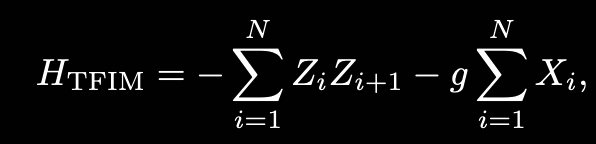

Z2 symmetry, we can invert all spins in z direction and that won't change results.

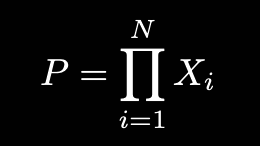

To quickly prove that they indeed commute, first we notice that the $X_i$ terms trivially commute with the $X$ product. But not for the other case, we can just see that:

$$I\otimes \dots \otimes Z_i \otimes Z_i+1 \otimes I \otimes \dots \otimes I$$


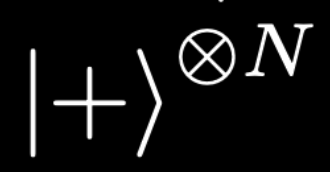

We start with initial state that is in ground state parity, which we argue to be +. And then, we construct parity invariant ansatz:

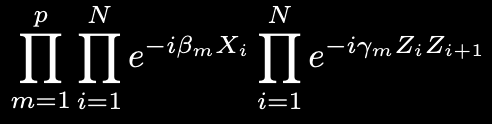


But also, more expressive but not invariant a priori "mixer" ansatz:

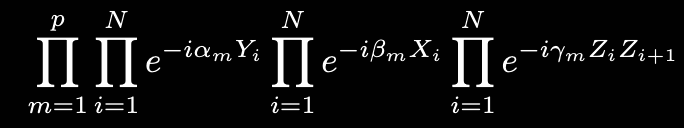

In [421]:
def TFHamiltonian(g, L):
    Ham = pauliString('Z'+'I'*(L-2)+'Z') + g*pauliString('I'*(L-1)+'X')
    for l in range(L-1):
        Ham += pauliString('I'*(l)+'ZZ'+'I'*(L-l-2)) + g*pauliString(l*'I'+'X' + (L-l-1)*'I')
    return -Ham

N = 6

def TFCircuit(params, N, hyper=dict(p=3)):
    r = idK(N)
    for m in range(p):
        for i in range(N-1):
            r = expm(-1j*params[2*N*m + i]*pauliString('I'*(i)+'ZZ'+'I'*(N-i-2)))@r
        r = expm(-1j*params[2*N*m + N-1]*pauliString('Z'+'I'*(N-2)+'Z'))@r
        for i in range(N):
            r = expm(-1j*params[2*N*m + N + i]*pauliString('I'*(i)+'X'+'I'*(N-i-1)))@r
            
    return r

def TFCircuitMixer(params, N, hyper=dict(p=3)):
    r = idK(N)
    for m in range(hyper['p']):
        for i in range(N-1):
            r = expm(-1j*params[3*N*m + i]*pauliString('I'*(i)+'ZZ'+'I'*(N-i-2)))@r
        r = expm(-1j*params[3*N*m + N-1]*pauliString('Z'+'I'*(N-2)+'Z'))@r
        for i in range(N):
            r = expm(-1j*params[3*N*m + N + i]*pauliString('I'*(i)+'X'+'I'*(N-i-1)))@r
        for i in range(N):
            r = expm(-1j*params[3*N*m + 2*N + i]*pauliString('I'*(i)+'Y'+'I'*(N-i-1)))@r
            
    return r


# We start with state |+++++++> always
def encoder(input, N, hyper):
    r = idK(N)
    for q in range(N):
        r = operatorN(pauli('H'), q, N)@r
    return r




In [423]:
N = 6
p = N//2
hyper = dict(p=p)
g = 1

Ham = TFHamiltonian(g, N)

exactG, exactE = gstate(Ham)
params = pt.rand((hyper['p']*2*N), requires_grad=True)
print(len(params))

print("Exact E:", exactE)
#printState(exactG)

Elist = []

lr = 0.005
Nepochs = 50

optimizer = pt.optim.LBFGS([params])

print(len(optimizer._params[0]))


params, Elist = genericOptimizer(N, [0], encoder, optimizer, TFCircuit, observable = Ham, loss_func=lambda x, y: x, 
                Nepochs=Nepochs, lr=lr, epochs_print=5,encoder_type='circuit', optimizer_closure=True)

plt.plot(Elist)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.plot([0,Nepochs-1], [exactE,exactE], '--', label='exact g.s. energy')

36
Exact E: tensor(-7.7274)
36


TypeError: float() argument must be a string or a number, not 'NoneType'

Exact E: tensor(-7.7274)
(-0.5138510465621948+0j) |000000>
(-0.14793825149536133+0j) |000001>
(-0.14793825149536133+0j) |000010>
(-0.0942932665348053+0j) |000011>
(-0.14793828129768372+0j) |000100>
(-0.04919356107711792+0j) |000101>
(-0.09429320693016052+0j) |000110>
(-0.08303213119506836+0j) |000111>
(-0.14793828129768372+0j) |001000>
(-0.04647761955857277+0j) |001001>
(-0.04919356480240822+0j) |001010>
(-0.03905749320983887+0j) |001011>
(-0.09429328143596649+0j) |001100>
(-0.039057496935129166+0j) |001101>
(-0.08303213864564896+0j) |001110>
(-0.09429284185171127+0j) |001111>
(-0.14793828129768372+0j) |010000>
(-0.04919356107711792+0j) |010001>
(-0.04647761583328247+0j) |010010>
(-0.03905748948454857+0j) |010011>
(-0.04919356852769852+0j) |010100>
(-0.021501509472727776+0j) |010101>
(-0.03905748203396797+0j) |010110>
(-0.04919325187802315+0j) |010111>
(-0.09429329633712769+0j) |011000>
(-0.039057496935129166+0j) |011001>
(-0.03905748575925827+0j) |011010>
(-0.0464773029088974+0j) |011

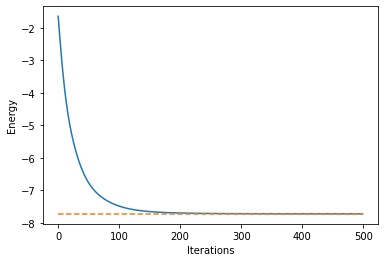

In [378]:
N = 6
p = N//2
hyper = dict(p=p)
g = 1

Ham = TFHamiltonian(g, N)

exactG, exactE = gstate(Ham)
params = pt.rand((hyper['p']*2*N), requires_grad=True)


#s0 = pt.ones((2**N,))/2**(N/2)+0j

print("Exact E:", exactE)
printState(exactG)

Elist = []

lr = 0.005
Nepochs = 500


params, Elist = simpleOptimizer(N, [0], encoder, params, TFCircuit, observable = Ham, loss_func=lambda x, y: x, 
                Nepochs=Nepochs, lr=lr, epochs_print=5,encoder_type='circuit')
"""
for epoch in range(Nepochs):
    circ0 = TFCircuit(params,N,p)
    energy = pt.real(expectation(circ0@s0, Ham)) # we want to minimize energy!!!
    energy.backward()  # we compute gradients

    Elist.append(energy.detach().numpy())
    
    with pt.no_grad():
        params = params - lr * params.grad
    params.requires_grad = True
    if epoch % 5 == 0 or epoch == Nepochs - 1:
        print(f"Epoch {epoch}, Energy: {energy}")"""

plt.plot(Elist)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.plot([0,Nepochs-1], [exactE,exactE], '--', label='exact g.s. energy')

Exact E: tensor(-7.7274)
(-0.5138510465621948+0j) |000000>
(-0.14793825149536133+0j) |000001>
(-0.14793825149536133+0j) |000010>
(-0.0942932665348053+0j) |000011>
(-0.14793828129768372+0j) |000100>
(-0.04919356107711792+0j) |000101>
(-0.09429320693016052+0j) |000110>
(-0.08303213119506836+0j) |000111>
(-0.14793828129768372+0j) |001000>
(-0.04647761955857277+0j) |001001>
(-0.04919356480240822+0j) |001010>
(-0.03905749320983887+0j) |001011>
(-0.09429328143596649+0j) |001100>
(-0.039057496935129166+0j) |001101>
(-0.08303213864564896+0j) |001110>
(-0.09429284185171127+0j) |001111>
(-0.14793828129768372+0j) |010000>
(-0.04919356107711792+0j) |010001>
(-0.04647761583328247+0j) |010010>
(-0.03905748948454857+0j) |010011>
(-0.04919356852769852+0j) |010100>
(-0.021501509472727776+0j) |010101>
(-0.03905748203396797+0j) |010110>
(-0.04919325187802315+0j) |010111>
(-0.09429329633712769+0j) |011000>
(-0.039057496935129166+0j) |011001>
(-0.03905748575925827+0j) |011010>
(-0.0464773029088974+0j) |011

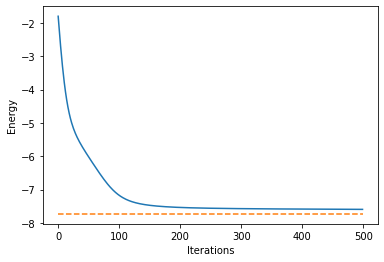

In [371]:
N = 6
p = N//2
g = 1
Ham = TFHamiltonian(g, N)

exactG, exactE = gstate(Ham)
params = pt.rand((p*2*N), requires_grad=True)


s0 = pt.ones((2**N,))/2**(N/2)+0j

print("Exact E:", exactE)
printState(exactG)

Elist = []

lr = 0.005
Nepochs = 500
for epoch in range(Nepochs):
    circ0 = TFCircuit(params,N,p)
    energy = pt.real(expectation(circ0@s0, Ham)) # we want to minimize energy!!!
    energy.backward()  # we compute gradients

    Elist.append(energy.detach().numpy())
    
    with pt.no_grad():
        params = params - lr * params.grad
    params.requires_grad = True
    if epoch % 5 == 0 or epoch == Nepochs - 1:
        print(f"Epoch {epoch}, Energy: {energy}")

plt.plot(Elist)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.plot([0,Nepochs-1], [exactE,exactE], '--', label='exact g.s. energy')

Exact E: tensor(-7.7274)
(-0.5138510465621948+0j) |000000>
(-0.14793825149536133+0j) |000001>
(-0.14793825149536133+0j) |000010>
(-0.0942932665348053+0j) |000011>
(-0.14793828129768372+0j) |000100>
(-0.04919356107711792+0j) |000101>
(-0.09429320693016052+0j) |000110>
(-0.08303213119506836+0j) |000111>
(-0.14793828129768372+0j) |001000>
(-0.04647761955857277+0j) |001001>
(-0.04919356480240822+0j) |001010>
(-0.03905749320983887+0j) |001011>
(-0.09429328143596649+0j) |001100>
(-0.039057496935129166+0j) |001101>
(-0.08303213864564896+0j) |001110>
(-0.09429284185171127+0j) |001111>
(-0.14793828129768372+0j) |010000>
(-0.04919356107711792+0j) |010001>
(-0.04647761583328247+0j) |010010>
(-0.03905748948454857+0j) |010011>
(-0.04919356852769852+0j) |010100>
(-0.021501509472727776+0j) |010101>
(-0.03905748203396797+0j) |010110>
(-0.04919325187802315+0j) |010111>
(-0.09429329633712769+0j) |011000>
(-0.039057496935129166+0j) |011001>
(-0.03905748575925827+0j) |011010>
(-0.0464773029088974+0j) |011

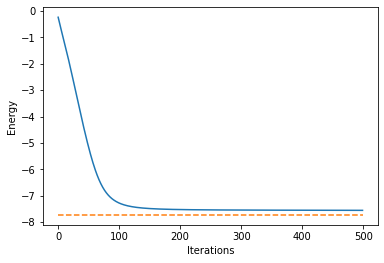

In [241]:
N = 6
p = N//2
g = 1
Ham = TFHamiltonian(g, N)

exactG, exactE = gstate(Ham)
params = pt.rand((p*3*N), requires_grad=True)


s0 = pt.ones((2**N,))/2**(N/2)+0j

print("Exact E:", exactE)
printState(exactG)

Elist = []

lr = 0.005
Nepochs = 500
for epoch in range(Nepochs):
    circ0 = TFCircuitMixer(params,N,p)
    energy = pt.real(expectation(circ0@s0, Ham)) # we want to minimize energy!!!
    energy.backward()  # we compute gradients

    Elist.append(energy.detach().numpy())
    
    with pt.no_grad():
        params = params - lr * params.grad
    params.requires_grad = True
    if epoch % 5 == 0 or epoch == Nepochs - 1:
        print(f"Epoch {epoch}, Energy: {energy}")

plt.plot(Elist)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.plot([0,Nepochs-1], [exactE,exactE], '--', label='exact g.s. energy')

Exact E: tensor(-7.7274)
(-0.5138510465621948+0j) |000000>
(-0.14793825149536133+0j) |000001>
(-0.14793825149536133+0j) |000010>
(-0.0942932665348053+0j) |000011>
(-0.14793828129768372+0j) |000100>
(-0.04919356107711792+0j) |000101>
(-0.09429320693016052+0j) |000110>
(-0.08303213119506836+0j) |000111>
(-0.14793828129768372+0j) |001000>
(-0.04647761955857277+0j) |001001>
(-0.04919356480240822+0j) |001010>
(-0.03905749320983887+0j) |001011>
(-0.09429328143596649+0j) |001100>
(-0.039057496935129166+0j) |001101>
(-0.08303213864564896+0j) |001110>
(-0.09429284185171127+0j) |001111>
(-0.14793828129768372+0j) |010000>
(-0.04919356107711792+0j) |010001>
(-0.04647761583328247+0j) |010010>
(-0.03905748948454857+0j) |010011>
(-0.04919356852769852+0j) |010100>
(-0.021501509472727776+0j) |010101>
(-0.03905748203396797+0j) |010110>
(-0.04919325187802315+0j) |010111>
(-0.09429329633712769+0j) |011000>
(-0.039057496935129166+0j) |011001>
(-0.03905748575925827+0j) |011010>
(-0.0464773029088974+0j) |011

Epoch 0, Energy: 0.917304277420044
Epoch 5, Energy: 0.5913465023040771
Epoch 10, Energy: 0.13845059275627136
Epoch 15, Energy: -0.4668349623680115
Epoch 20, Energy: -1.2259587049484253
Epoch 25, Energy: -2.097297191619873
Epoch 30, Energy: -2.9946231842041016
Epoch 35, Energy: -3.8165388107299805
Epoch 40, Energy: -4.489782333374023
Epoch 45, Energy: -4.991433620452881
Epoch 50, Energy: -5.339201927185059
Epoch 55, Energy: -5.568440914154053
Epoch 60, Energy: -5.714792251586914
Epoch 65, Energy: -5.8065290451049805
Epoch 70, Energy: -5.863597393035889
Epoch 75, Energy: -5.899106979370117
Epoch 80, Energy: -5.921417236328125
Epoch 85, Energy: -5.9356794357299805
Epoch 90, Energy: -5.945047378540039
Epoch 95, Energy: -5.951455116271973
Epoch 100, Energy: -5.955988883972168
Epoch 105, Energy: -5.959406852722168
Epoch 110, Energy: -5.962125778198242
Epoch 115, Energy: -5.964354515075684
Epoch 120, Energy: -5.966282844543457
Epoch 125, Energy: -5.967991352081299
Epoch 130, Energy: -5.969552

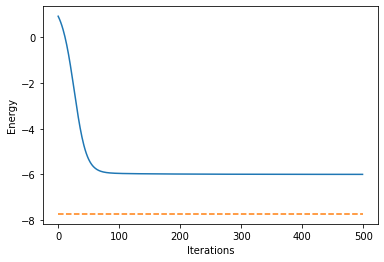

In [235]:
N = 6
p = N//2
g = 1
Ham = TFHamiltonian(g, N)

exactG, exactE = gstate(Ham)
params = pt.rand((p*2*N), requires_grad=True)


s0 = pt.ones((2**N,))/2**(N/2)+0j

print("Exact E:", exactE)
printState(exactG)

Elist = []

lr = 0.0005
Nepochs = 500
for epoch in range(Nepochs):
    circ0 = simpleCircuitTranslation(params[:3])@simpleCircuitTranslation(params[3:6])@simpleCircuitTranslation(params[6:9])@simpleCircuitTranslation(params[9:12])
    energy = pt.real(expectation(circ0@s0, Ham)) # we want to minimize energy!!!
    energy.backward()  # we compute gradients

    Elist.append(energy.detach().numpy())
    
    with pt.no_grad():
        params = params - lr * params.grad
    params.requires_grad = True
    if epoch % 5 == 0 or epoch == Nepochs - 1:
        print(f"Epoch {epoch}, Energy: {energy}")

plt.plot(Elist)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.plot([0,Nepochs-1], [exactE,exactE], '--', label='exact g.s. energy')

### With Qibo

we heuristically showed some interesting differences in behaviour, but we would like to compare with some results. 

We compare now this problem with results from: Meyer, Johannes Jakob, Marian Mularski, Elies Gil-Fuster, Antonio Anna Mele, Francesco Arzani, Alissa Wilms, and Jens Eisert. “Exploiting Symmetry in Variational Quantum Machine Learning.” PRX Quantum 4, no. 1 (March 17, 2023): 010328. https://doi.org/10.1103/PRXQuantum.4.010328.


They use there a BFGS Method, so to compare we also use this method which is implemented in Qibo via scipy. But there is one problem, the implementation of this method, a quasi-newtonian method, requires a calculation of an approximation or an exact version of the gradient of the function. The problem is that for the Qibo implementation, the actual way this is done is through a finite difference method to estimate derivatives! This means that possibly there may be some problems here, although it seems to converge well, but we consider the possibility that these gradients could also be obtained analytically via the parameter shift rule!

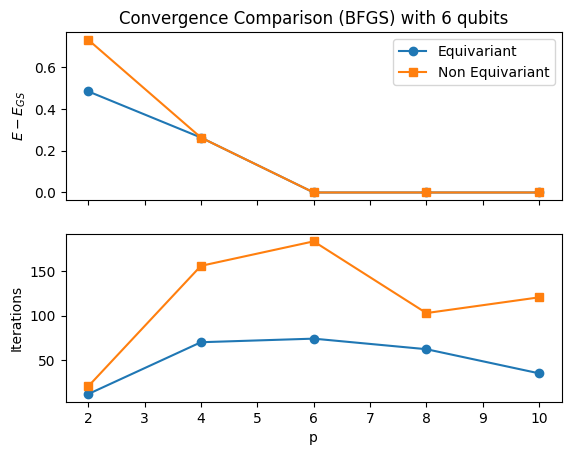

In [2]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(2,1, sharex=True)
plt.xlabel('p')
plist = np.array([2,4,6,8,10])


import re
from ast import literal_eval

import numpy as np

e1list = """[[-7.24264068 -7.24264069 -7.24264069 -7.24264069 -7.24264068]
 [-7.46410151 -7.46410159 -7.46410157 -7.46410076 -7.46410159]
 [-7.72740657 -7.72740654 -7.72740656 -7.72740659 -7.72740658]
 [-7.72740658 -7.72740655 -7.72740656 -7.7274066  -7.72740659]
 [-7.7274066  -7.7274066  -7.72740659 -7.7274066  -7.72740657]
 [-7.72740656 -7.7274066  -7.72740657 -7.72740658 -7.72740659]
 [-7.72740658 -7.7274066  -7.72740659 -7.72740658 -7.7274066 ]
 [-7.72740659 -7.7274066  -7.7274066  -7.7274066  -7.72740659]]"""
e1list = re.sub(r"([^[])\s+([^]])", r"\1, \2", e1list)
e1list = np.array(literal_eval(e1list))[:5,:]

n1list = """[[12. 13. 14. 12. 11.]
 [55. 85. 74. 54. 84.]
 [87. 96. 76. 56. 57.]
 [68. 82. 61. 44. 58.]
 [34. 28. 39. 30. 47.]
 [42. 30. 30. 27. 36.]
 [37. 30. 37. 26. 25.]
 [30. 20. 35. 24. 36.]]"""
n1list = re.sub(r"([^[])\s+([^]])", r"\1, \2", n1list)
n1list = np.array(literal_eval(n1list))[:5, :]


e2list = """[[-7.24264068 -6.00564374 -7.24264069 -7.24264069 -7.24264068]
 [-7.46410123 -7.46410133 -7.46410056 -7.46410145 -7.46410112]
 [-7.72740591 -7.72740647 -7.72740652 -7.72740636 -7.72740593]
 [-7.7274063  -7.72740621 -7.72740643 -7.72740635 -7.72740646]
 [-7.72740572 -7.72740638 -7.72740649 -7.72740634 -7.72740645]
 [-7.72740659 -7.72740658 -7.72740655 -7.72740655 -7.72740657]
 [-7.72740635 -7.72740583 -7.72740137 -7.72740406 -7.72740551]
 [-7.72740449 -7.72740361 -7.72740641 -7.72739893 -7.72740562]]"""
e2list = re.sub(r"([^[])\s+([^]])", r"\1, \2", e2list)
e2list = np.array(literal_eval(e2list))[:5,:]

n2list = """[[ 17.  34.  15.  19.  20.]
 [ 82. 243. 246.  77. 131.]
 [312. 187.  93. 131. 193.]
 [ 99.  80.  92.  98. 146.]
 [169. 121. 111.  81. 121.]
 [ 60.  53.  52.  98.  78.]
 [222. 124.  90.  95. 152.]
 [186. 124. 109. 150. 126.]]"""
n2list = re.sub(r"([^[])\s+([^]])", r"\1, \2", n2list)
n2list = np.array(literal_eval(n2list))[:5, :]

gse = -7.72740661031255

axs[0].set_title('Convergence Comparison (BFGS) with 6 qubits')
axs[0].plot(plist, np.average(e1list-gse, axis=1), '-o', label='Equivariant')
axs[0].plot(plist, np.average(e2list-gse, axis=1), '-s', label='Non Equivariant')
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].legend(loc='upper right')

axs[1].plot(plist, np.average(n1list, axis=1), '-o', label='Equivariant')
axs[1].plot(plist, np.average(n2list, axis=1), '-s', label='Non Equivariant')
axs[1].set_ylabel('Iterations')



plt.show()

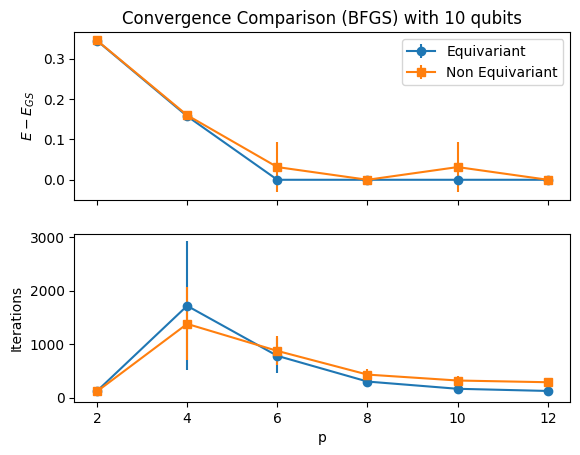

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(2,1, sharex=True)
plt.xlabel('p')
plist = np.array([2,4,6,8,10,12])


import re
from ast import literal_eval

import numpy as np

e1list = """[[-12.44016936 -12.44016936 -12.44016936 -12.44016936 -12.44016936 -1.24401694e+001 -1.24401694e+001 -1.24401694e+001 -1.24401694e+001
  -1.24401692e+001]
 [-12.62750302 -12.62710627 -12.6275029  -12.62705548 -12.62750301 -1.26270797e+001 -1.26275029e+001 -1.26275030e+001 -1.26275030e+001
  -1.26240820e+001]
 [-12.78490613 -12.78490594 -12.78490639 -12.78490579 -12.78490614 -1.27849064e+001 -1.27849063e+001 -1.27849059e+001 -1.27849058e+001
  -1.27849061e+001]
 [-12.78490641 -12.78490606 -12.78490618 -12.78490638 -12.78490617 -1.27849064e+001 -1.27849061e+001 -1.27849058e+001 -1.27849064e+001
  -1.27849064e+001]
 [-12.78490642 -12.78490632 -12.7849064  -12.78490643 -12.78490643 -1.27849063e+001 -1.27849064e+001 -1.27849064e+001 -1.27849064e+001
  -1.27849064e+001]
 [-12.78490643 -12.78490644 -12.78490644 -12.78490642 -12.78490643 -1.27849064e+001 -1.27849064e+001 -1.27849064e+001 -1.27849064e+001
  -1.27849064e+001]]"""
e1list = re.sub(r"([^[])\s+([^]])", r"\1, \2", e1list)
e1list = np.array(literal_eval(e1list))[:,:6]

n1list = """[[ 9.50000000e+001  8.30000000e+001  2.35000000e+002  1.59000000e+002
   9.80000000e+001  7.90000000e+001  6.10000000e+001  9.20000000e+001  1.14000000e+002
   2.09000000e+002]
 [ 2.64800000e+003  3.89100000e+003  3.49000000e+002  2.04200000e+003
   1.43500000e+003  2.19300000e+003  3.38000000e+002  3.13400000e+003  3.72000000e+002
   7.59000000e+002]
 [ 6.39000000e+002  5.23000000e+002  8.39000000e+002  5.29000000e+002
   6.26000000e+002  1.37800000e+003  7.58000000e+002  5.23000000e+002  1.43400000e+003
   5.63000000e+002]
 [ 3.62000000e+002  3.08000000e+002  3.44000000e+002  3.41000000e+002
   2.55000000e+002  2.49000000e+002  4.13000000e+002  2.83000000e+002  3.32000000e+002
   1.21000000e+002]
 [ 1.36000000e+002  3.07000000e+002  1.30000000e+002  1.63000000e+002
   1.28000000e+002  2.12000000e+002  9.50000000e+001  1.53000000e+002  1.45000000e+002
   1.88000000e+002]
 [ 9.50000000e+001  8.00000000e+001  1.23000000e+002  1.22000000e+002
   1.64000000e+002  1.19000000e+002  9.10000000e+001  1.07000000e+002  1.99000000e+002
   1.52000000e+002]]"""
n1list = re.sub(r"([^[])\s+([^]])", r"\1, \2", n1list)
n1list = np.array(literal_eval(n1list))[:, :]


e2list = """[[-1.24401694e+001 -1.24401694e+001 -1.24401693e+001 -1.24401694e+001
  -1.24401694e+001 -1.24401693e+001 -1.24401694e+001 -1.24401694e+001 -1.24347453e+001
  -1.24401693e+001]
 [-1.26241221e+001 -1.26241088e+001 -1.26275029e+001 -1.26241194e+001
  -1.26241164e+001 -1.26216292e+001 -1.26275030e+001 -1.26243242e+001 -1.26240832e+001
  -1.26275019e+001]
 [-1.26275023e+001 -1.27849060e+001 -1.27849064e+001 -1.27849060e+001
  -1.27849062e+001 -1.26274979e+001 -1.27849062e+001 -1.27849064e+001 -1.27849063e+001
  -1.27849062e+001]
 [-1.27849063e+001 -1.27849063e+001 -1.27849064e+001 -1.27849064e+001
  -1.27849056e+001 -1.27849059e+001 -1.27849064e+001 -1.27849060e+001 -1.27849063e+001
  -1.27849060e+001]
 [-1.27849062e+001 -1.27849063e+001 -1.27849063e+001 -1.26275026e+001
  -1.27849064e+001 -1.27849064e+001 -1.26275016e+001 -1.27849061e+001 -1.27849057e+001
  -1.27849063e+001]
 [-1.27849063e+001 -1.27849064e+001 -1.27849062e+001 -1.27849060e+001
  -1.27849063e+001 -1.27849059e+001 -1.27849064e+001 -1.27849062e+001 -1.27849064e+001
  -1.27849061e+001]]"""
e2list = re.sub(r"([^[])\s+([^]])", r"\1, \2", e2list)
e2list = np.array(literal_eval(e2list))[:,:]

n2list = """[[ 8.40000000e+001  1.84000000e+002  6.60000000e+001  1.07000000e+002
   1.26000000e+002  7.10000000e+001 1.13000000e+002 2.22000000e+002 1.14000000e+002
  7.10000000e+001]
 [ 8.18000000e+002  1.88100000e+003  3.85000000e+002  1.01500000e+003
   1.19000000e+003  1.95600000e+003 2.80200000e+003 1.40800000e+003 6.89000000e+002
  1.64100000e+003]
 [ 5.84000000e+002  5.08000000e+002  9.24000000e+002  6.51000000e+002
   1.45400000e+003  9.38000000e+002 8.02000000e+002 1.19300000e+003 7.66000000e+002
  9.17000000e+002]
 [ 4.02000000e+002  4.61000000e+002  4.30000000e+002  4.68000000e+002
   6.14000000e+002  4.61000000e+002 3.06000000e+002 3.26000000e+002 2.93000000e+002
  5.49000000e+002]
 [ 4.14000000e+002  3.30000000e+002  2.88000000e+002  4.59000000e+002
   1.66000000e+002  2.01000000e+002 2.95000000e+002 3.57000000e+002 3.62000000e+002
  3.31000000e+002]
 [ 2.86000000e+002  2.20000000e+002  4.28000000e+002  2.24000000e+002
   3.74000000e+002  2.88000000e+002 2.12000000e+002 2.48000000e+002 2.88000000e+002
  3.14000000e+002]]"""
n2list = re.sub(r"([^[])\s+([^]])", r"\1, \2", n2list)
n2list = np.array(literal_eval(n2list))[:, :]

gse = -12.784906442999327

axs[0].set_title('Convergence Comparison (BFGS) with 10 qubits')
axs[0].errorbar(plist, np.average(e1list-gse, axis=1), fmt='-o', yerr=np.sqrt(np.var(e1list-gse, axis=1)), label='Equivariant')
axs[0].errorbar(plist, np.average(e2list-gse, axis=1), fmt='-s', yerr=np.sqrt(np.var(e2list-gse, axis=1)), label='Non Equivariant')
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].legend(loc='upper right')

axs[1].errorbar(plist, np.average(n1list, axis=1), fmt='-o', yerr=np.sqrt(np.var(n1list, axis=1)), label='Equivariant')
axs[1].errorbar(plist, np.average(n2list, axis=1), fmt='-s', yerr=np.sqrt(np.var(n2list, axis=1)), label='Non Equivariant')
axs[1].set_ylabel('Iterations')



plt.show()



Speed: Torch Compile??

In [424]:
pt.compile(TFCircuit)

<function __main__.TFCircuit(params, N, hyper={'p': 3})>

In [426]:
pt.__version__

'2.2.2'

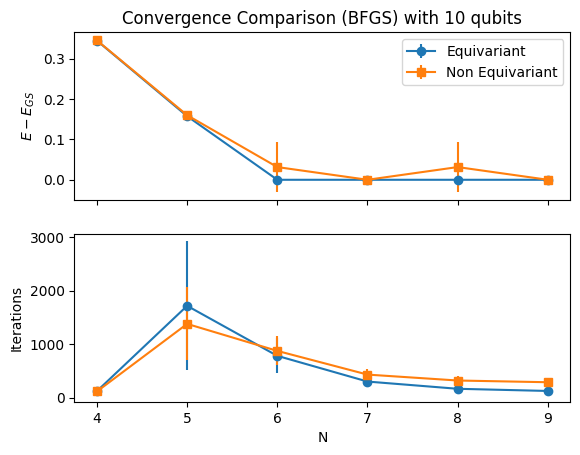

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(2,1, sharex=True)
plt.xlabel('N')
plist = range(2,13,2)


import re
from ast import literal_eval

import numpy as np

e1list = """[[-12.44016936 -12.44016936 -12.44016936 -12.44016936 -12.44016936 -1.24401694e+001 -1.24401694e+001 -1.24401694e+001 -1.24401694e+001
  -1.24401692e+001]
 [-12.62750302 -12.62710627 -12.6275029  -12.62705548 -12.62750301 -1.26270797e+001 -1.26275029e+001 -1.26275030e+001 -1.26275030e+001
  -1.26240820e+001]
 [-12.78490613 -12.78490594 -12.78490639 -12.78490579 -12.78490614 -1.27849064e+001 -1.27849063e+001 -1.27849059e+001 -1.27849058e+001
  -1.27849061e+001]
 [-12.78490641 -12.78490606 -12.78490618 -12.78490638 -12.78490617 -1.27849064e+001 -1.27849061e+001 -1.27849058e+001 -1.27849064e+001
  -1.27849064e+001]
 [-12.78490642 -12.78490632 -12.7849064  -12.78490643 -12.78490643 -1.27849063e+001 -1.27849064e+001 -1.27849064e+001 -1.27849064e+001
  -1.27849064e+001]
 [-12.78490643 -12.78490644 -12.78490644 -12.78490642 -12.78490643 -1.27849064e+001 -1.27849064e+001 -1.27849064e+001 -1.27849064e+001
  -1.27849064e+001]]"""
e1list = re.sub(r"([^[])\s+([^]])", r"\1, \2", e1list)
e1list = np.array(literal_eval(e1list))[:,:6]


e2list = """[[-1.24401694e+001 -1.24401694e+001 -1.24401693e+001 -1.24401694e+001
  -1.24401694e+001 -1.24401693e+001 -1.24401694e+001 -1.24401694e+001 -1.24347453e+001
  -1.24401693e+001]
 [-1.26241221e+001 -1.26241088e+001 -1.26275029e+001 -1.26241194e+001
  -1.26241164e+001 -1.26216292e+001 -1.26275030e+001 -1.26243242e+001 -1.26240832e+001
  -1.26275019e+001]
 [-1.26275023e+001 -1.27849060e+001 -1.27849064e+001 -1.27849060e+001
  -1.27849062e+001 -1.26274979e+001 -1.27849062e+001 -1.27849064e+001 -1.27849063e+001
  -1.27849062e+001]
 [-1.27849063e+001 -1.27849063e+001 -1.27849064e+001 -1.27849064e+001
  -1.27849056e+001 -1.27849059e+001 -1.27849064e+001 -1.27849060e+001 -1.27849063e+001
  -1.27849060e+001]
 [-1.27849062e+001 -1.27849063e+001 -1.27849063e+001 -1.26275026e+001
  -1.27849064e+001 -1.27849064e+001 -1.26275016e+001 -1.27849061e+001 -1.27849057e+001
  -1.27849063e+001]
 [-1.27849063e+001 -1.27849064e+001 -1.27849062e+001 -1.27849060e+001
  -1.27849063e+001 -1.27849059e+001 -1.27849064e+001 -1.27849062e+001 -1.27849064e+001
  -1.27849061e+001]]"""
e2list = re.sub(r"([^[])\s+([^]])", r"\1, \2", e2list)
e2list = np.array(literal_eval(e2list))[:,:]


gse = -12.784906442999327

axs[0].set_title('Convergence Comparison (BFGS) with 10 qubits')
axs[0].errorbar(plist, np.average(e1list-gse, axis=1), fmt='-o', yerr=np.sqrt(np.var(e1list-gse, axis=1)), label='Equivariant')
axs[0].errorbar(plist, np.average(e2list-gse, axis=1), fmt='-s', yerr=np.sqrt(np.var(e2list-gse, axis=1)), label='Non Equivariant')
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].legend(loc='upper right')

axs[1].errorbar(plist, np.average(n1list, axis=1), fmt='-o', yerr=np.sqrt(np.var(n1list, axis=1)), label='Equivariant')
axs[1].errorbar(plist, np.average(n2list, axis=1), fmt='-s', yerr=np.sqrt(np.var(n2list, axis=1)), label='Non Equivariant')
axs[1].set_ylabel('Iterations')



plt.show()